<a href="https://colab.research.google.com/github/sikha2552/Meta-UNet/blob/main/Metal_UNET_PH2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meta-UNet- PH2 Dataset

## 1. Import Libraries

In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:
# if running on google colab
train_path = '/content/drive/MyDrive/Alaysia/PH2Dataset/Train_X/*.bmp'
ground_truth_path = '/content/drive/MyDrive/Alaysia/PH2Dataset/Train_Y/*.bmp'
test_path= '/content/drive/MyDrive/Alaysia/PH2Dataset/Test_X/*.bmp'
test_gt= '/content/drive/MyDrive/Alaysia/PH2Dataset/Test_Y/*.bmp'

## 2. Image Loading and Preprocessing

In [ ]:
import numpy as np
from PIL import Image
import glob
import os

def numericalSort(value):
    import re
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Desired shape for the images
TARGET_SHAPE = (224, 224)  # Adjust based on your input requirements

# Process training images
filelist_trainx = sorted(glob.glob(train_path), key=numericalSort)
X_train = np.array([np.array(Image.open(fname).resize(TARGET_SHAPE)) for fname in filelist_trainx])

# Process ground truth images
filelist_trainy = sorted(glob.glob(ground_truth_path), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname).resize(TARGET_SHAPE)) for fname in filelist_trainy])

# Process test images
filelist_testx = sorted(glob.glob(test_path), key=numericalSort)
X_test = np.array([np.array(Image.open(fname).resize(TARGET_SHAPE)) for fname in filelist_testx])

# Process ground truth images
filelist_testy = sorted(glob.glob(test_gt), key=numericalSort)
Y_test = np.array([np.array(Image.open(fname).resize(TARGET_SHAPE)) for fname in filelist_testy])

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_testshape: {Y_test.shape}")

X_train shape: (160, 224, 224, 3)
Y_train shape: (160, 224, 224)
X_test shape: (40, 224, 224, 3)
Y_testshape: (40, 224, 224)


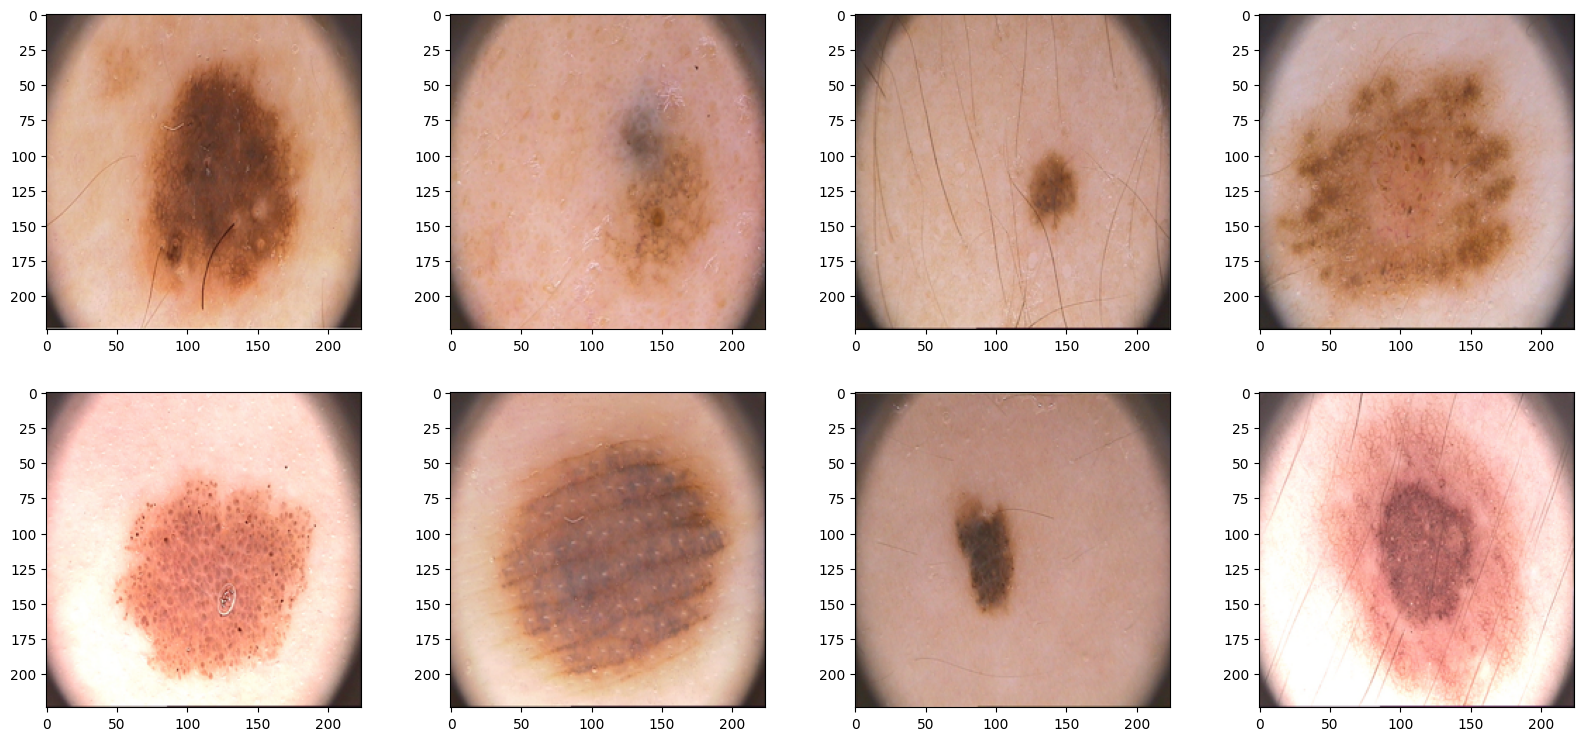

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.reduce_sum(tf.square(y_true), axis=-1) + tf.reduce_sum(tf.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return 1 - jac

def iou(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    sum_ = tf.reduce_sum(tf.square(y_true), axis=-1) + tf.reduce_sum(tf.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coe(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def precision(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def recall(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def accuracy(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))

## 3. Process Meta Data

In [ ]:
import pandas as pd
# Load Meta data
file_path = '/content/drive/MyDrive/Alaysia/PH2Dataset/meta_train.xlsx'
med_data_raw = pd.read_excel(file_path)
print(f"Length of metadata: {len(med_data_raw)}")
file_path_test='/content/drive/MyDrive/Alaysia/PH2Dataset/meta_test.xlsx'
med_data_test = pd.read_excel(file_path_test)
print(f"Length of metadata: {len(med_data_test)}")


Length of metadata: 160
Length of metadata: 40


In [ ]:
print(f"Length of x_train: {len(X_train)}")
print(f"Length of y_train: {len(Y_train)}")
print(f"Length of med_data_raw: {len(med_data_raw)}")
print(f"Length of med_data_raw: {len(med_data_test)}")


Length of x_train: 160
Length of y_train: 160
Length of med_data_raw: 160
Length of med_data_raw: 40


In [ ]:
# Image Augmentation byconsidering meta data
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')
def img_augmentation(x_train, y_train, metadata_train):
    x_rotat, y_rotat, metadata_rotat = [], [], []
    x_flip, y_flip, metadata_flip = [], [], []

    for idx in range(len(x_train)):
        x, y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        metadata_rotat.append(metadata_train.iloc[idx])  # Preserve row structure

        x, y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        metadata_flip.append(metadata_train.iloc[idx])  # Preserve row structure

    # Convert augmented metadata back to DataFrame
    metadata_rotat_df = pd.DataFrame(metadata_rotat, columns=metadata_train.columns)
    metadata_flip_df = pd.DataFrame(metadata_flip, columns=metadata_train.columns)

    return np.array(x_rotat), np.array(y_rotat), metadata_rotat_df, np.array(x_flip), np.array(y_flip), metadata_flip_df



In [ ]:
x_rotat, y_rotat, metadata_rotat_df, x_flip, y_flip, metadata_flip_df = img_augmentation(X_train, Y_train, med_data_raw)

# Combine original and augmented data
x_train_augmented = np.concatenate([X_train, x_rotat, x_flip], axis=0)
y_train_augmented = np.concatenate([Y_train, y_rotat, y_flip], axis=0)
metadata_train_augmented = pd.concat([med_data_raw, metadata_rotat_df, metadata_flip_df], axis=0)


In [ ]:
x_train_full = x_train_augmented
y_train_full = y_train_augmented
print(x_train_full.shape)
print(y_train_full.shape)
print(f"Length of metadata_train_augmented: {len(metadata_train_augmented)}")


(480, 224, 224, 3)
(480, 224, 224)
Length of metadata_train_augmented: 480


In [ ]:
# Split the augmented data into training and validation sets
x_train, x_val, y_train, y_val, metadata_train, metadata_val = train_test_split(
    x_train_full,
    y_train_full,
    metadata_train_augmented,  # Include metadata here
    test_size=0.20,
    random_state=101
)

print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Validation Set : {}".format(len(x_val)))
print("Length of the Metadata Training Set : {}".format(len(metadata_train)))
print("Length of the Metadata Validation Set : {}".format(len(metadata_val)))

Length of the Training Set   : 384
Length of the Validation Set : 96
Length of the Metadata Training Set : 384
Length of the Metadata Validation Set : 96


In [ ]:
metadata_train

,Image Name,Histological Diagnosis,Common Nevus,Atypical Nevus,Melanoma,Asymmetry,Pigment Network,Dots_Globules,Streaks,Regression Areas,Blue-Whitish Veil,White,Red,Light-Brown,Dark-Brown,Blue-Gray,Black
100,IMD157,NaN,NaN,X,NaN,2,AT,A,A,A,A,NaN,NaN,X,NaN,X,NaN
45,IMD143,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
43,IMD133,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,X,NaN,NaN,NaN
36,IMD017,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
135,IMD368,NaN,NaN,X,NaN,2,AT,A,A,A,A,NaN,NaN,X,X,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,IMD375,NaN,X,NaN,NaN,0,T,A,A,A,A,NaN,NaN,NaN,X,NaN,NaN
6,IMD035,NaN,X,NaN,NaN,2,T,A,A,A,A,NaN,X,X,NaN,NaN,NaN
17,IMD125,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,X,NaN,NaN
11,IMD050,NaN,X,NaN,NaN,0,T,T,A,A,A,NaN,NaN,X,NaN,NaN,NaN


## 4. Meta data embedding

In [ ]:
from tensorflow.keras.layers import Embedding, Flatten, Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import UpSampling2D, Conv2D, Activation, MaxPooling2D, SpatialDropout2D
from sklearn.preprocessing import LabelEncoder
# Encode metadata columns as integers
# Ensure columns names are sanitized and consistent
metadata_columns = ['Histological Diagnosis', 'Common Nevus', 'Atypical Nevus', 'Melanoma',
                    'Pigment Network', 'Dots_Globules', 'Streaks',
                    'Regression Areas', 'Blue-Whitish Veil']

# Encode metadata columns
metadata_encoders = {
    col: LabelEncoder().fit(metadata_train[col].astype(str)) for col in metadata_columns
}

# Encode training and validation metadata
encoded_metadata_train = np.column_stack([
    metadata_encoders[col].transform(metadata_train[col].astype(str)) for col in metadata_columns
])
encoded_metadata_val = np.column_stack([
    metadata_encoders[col].transform(metadata_val[col].astype(str)) for col in metadata_columns
])


In [ ]:
#Apply Embeddings:
import re

embedding_sizes = {col: min(50, len(metadata_encoders[col].classes_)) for col in metadata_columns}
metadata_inputs = []
metadata_embeddings = []
for col, input_dim in embedding_sizes.items():
    input_layer = Input(shape=(1,), name=f"{col}_input")
    embedding_layer = Embedding(input_dim=input_dim, output_dim=embedding_sizes[col], name=f"{col}_embedding")(input_layer)
    flattened_layer = Flatten()(embedding_layer)
    metadata_inputs.append(input_layer)
    metadata_embeddings.append(flattened_layer)

In [ ]:
# Concatenate all metadata embeddings
metadata_combined = Concatenate()(metadata_embeddings)
metadata_dense = Dense(128, activation='relu')(metadata_combined)
metadata_dense = Dense(64, activation='relu')(metadata_dense)

## 5. The Model (Meta-UNet)

In [ ]:
# Number of image channels
INPUT_CHANNELS = 3
# Number of output masks
OUTPUT_MASK_CHANNELS = 1


In [ ]:
from tensorflow.keras.layers import (
    Embedding, Flatten, Input, Dense, Concatenate, Reshape, Conv2D,
    Activation, MaxPooling2D, SpatialDropout2D, UpSampling2D, concatenate, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

def build_unet_with_metadata(img_shape, metadata_embedding_sizes, filters, dropout_val, OUTPUT_MASK_CHANNELS, epochs_num, x_train_images, x_train_metadata, y_train, x_val_images, x_val_metadata, y_val, savename):
    def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
        if K.image_data_format() == 'channels_first':
            axis = 1
        else:
            axis = 3
        conv = Conv2D(size, (3, 3), padding='same')(x)
        if batch_norm:
            conv = BatchNormalization(axis=axis)(conv)
        conv = Activation('relu')(conv)
        conv = Conv2D(size, (3, 3), padding='same')(conv)
        if batch_norm:
            conv = BatchNormalization(axis=axis)(conv)
        conv = Activation('relu')(conv)
        if dropout > 0:
            conv = SpatialDropout2D(dropout)(conv)
        return conv

    # Image input
    img_inputs = Input(shape=img_shape, name="Image_Input")

    # Metadata inputs and embeddings
    metadata_inputs = []
    metadata_embeddings = []
    for col, input_dim in metadata_embedding_sizes.items():
        input_layer = Input(shape=(1,), name=f"{col}_input")
        embedding_layer = Embedding(input_dim=input_dim, output_dim=metadata_embedding_sizes[col], name=f"{col}_embedding")(input_layer)
        flattened_layer = Flatten()(embedding_layer)
        metadata_inputs.append(input_layer)
        metadata_embeddings.append(flattened_layer)

    # Combine metadata embeddings into a dense layer
    metadata_combined = Concatenate(name="Metadata_Concatenated")(metadata_embeddings)
    metadata_dense = Dense(128, activation="relu", name="Metadata_Dense")(metadata_combined)

    # Encoder
    conv_224 = double_conv_layer(img_inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)
    conv_112 = double_conv_layer(pool_112, 2 * filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)
    conv_56 = double_conv_layer(pool_56, 4 * filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)
    conv_28 = double_conv_layer(pool_28, 8 * filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)
    conv_14 = double_conv_layer(pool_14, 16 * filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)
    conv_7 = double_conv_layer(pool_7, 32 * filters)

    # Concatenate metadata with bottleneck features
    bottleneck = Flatten()(conv_7)
    combined_features = Concatenate(name="Bottleneck_Concat")([bottleneck, metadata_dense])

    # Decoder
    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=-1)
    up_conv_14 = double_conv_layer(up_14, 16 * filters)
    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=-1)
    up_conv_28 = double_conv_layer(up_28, 8 * filters)
    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=-1)
    up_conv_56 = double_conv_layer(up_56, 4 * filters)
    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=-1)
    up_conv_112 = double_conv_layer(up_112, 2 * filters)
    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=-1)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    # Final layer
    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((img_shape[0], img_shape[1]))(conv_final)

    # Model
    model = Model(inputs=[img_inputs] + metadata_inputs, outputs=pred, name="UNET_224_with_Metadata")
    checkpoint = ModelCheckpoint(savename, monitor='val_loss', save_best_only=True, save_weights_only=True, mode='min', verbose=1)

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',  # Adjust this as needed
                  metrics=['accuracy',iou, dice_coe,])  # Add your custom metrics if required

    # Fit the model
    history = model.fit(   x=[x_train_images] + [encoded_metadata_train[:, i] for i in range(encoded_metadata_train.shape[1])],
    y=y_train,
    epochs=epochs_num,
    batch_size=32,
    validation_data=(
        [x_val_images] + [encoded_metadata_val[:, i] for i in range(encoded_metadata_val.shape[1])],
        y_val
    ),
    callbacks=[checkpoint],
    verbose=1
  )


    return model, history


In [ ]:
# For Training
# Define parameters
img_shape = (224, 224, 3)  # Example image shape (adjust as needed)
metadata_embedding_sizes = {
    'Histological Diagnosis': 10,  # Example number of unique classes
    'Common Nevus': 5,
    'Atypical Nevus': 5,
    'Melanoma': 5,
    'Pigment Network': 4,
    'Dots_Globules ': 4,
    'Streaks ': 4,
    'Regression Areas ': 4,
    'Blue-Whitish Veil ': 4,
}  # Replace these values with actual numbers of unique categories

filters = 32
dropout_val = 0.4
OUTPUT_MASK_CHANNELS = 1  # Assuming binary segmentation
epochs_num = 200

# Call the function
model, hist = build_unet_with_metadata(
    img_shape=img_shape,
    metadata_embedding_sizes=metadata_embedding_sizes,
    filters=filters,
    dropout_val=dropout_val,
    OUTPUT_MASK_CHANNELS=OUTPUT_MASK_CHANNELS,
    epochs_num=epochs_num,
    x_train_images=x_train,
    x_train_metadata=metadata_train,
    y_train=y_train,
    x_val_images=x_val,
    x_val_metadata=metadata_val,
    y_val=y_val,
    savename='/content/drive/MyDrive/Alaysia/PH2Dataset/weights/mednet_200_new_epoch.weights.h5'
)



Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.0226 - dice_coe: 0.3919 - iou: 0.6681 - loss: 0.8671
Epoch 1: val_loss improved from inf to 0.65096, saving model to /content/drive/MyDrive/Alaysia/PH2Dataset/weights/mednet_200_new_epoch.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.0226 - dice_coe: 0.3925 - iou: 0.6687 - loss: 0.8658 - val_accuracy: 0.2480 - val_dice_coe: 0.3362 - val_iou: 0.7078 - val_loss: 0.6510
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 580ms/step - accuracy: 0.0362 - dice_coe: 0.4507 - iou: 0.7126 - loss: 0.7212
Epoch 2: val_loss improved from 0.65096 to 0.56050, saving model to /content/drive/MyDrive/Alaysia/PH2Dataset/weights/mednet_200_new_epoch.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.0361 - dice_coe: 0.4516 - iou: 0.7132 - loss: 0.7197 - val_accuracy: 0.2398 - val_dice_coe: 0.3572 - val_iou: 0.7520 - val_loss: 0.5605
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.0417 - dice_coe: 0.

In [ ]:
# Plot the training curve
import matplotlib.pyplot as plt
# Extract training loss and validation loss from history
training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']
num_epochs=200
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#IF Testing
# Define parameters
img_shape = (224, 224, 3)  # Example image shape (adjust as needed)
metadata_embedding_sizes = {
    'Histological Diagnosis': 10,  # Example number of unique classes
    'Common Nevus': 5,
    'Atypical Nevus': 5,
    'Melanoma': 5,
    'Pigment Network': 4,
    'Dots_Globules ': 4,
    'Streaks ': 4,
    'Regression Areas ': 4,
    'Blue-Whitish Veil ': 4,
}
filters = 32
dropout_val = 0.4
OUTPUT_MASK_CHANNELS = 1
# Replace these values with actual numbers of unique categories

model = build_unet_with_metadata(
    img_shape=img_shape,
    metadata_embedding_sizes=metadata_embedding_sizes,
    filters=filters,
    dropout_val=dropout_val,
    OUTPUT_MASK_CHANNELS=OUTPUT_MASK_CHANNELS,
    epochs_num=200,
    x_train_images=x_train,
    x_train_metadata=metadata_train,
    y_train=y_train,
    x_val_images=x_val,
    x_val_metadata=metadata_val,
    y_val=y_val,
    savename='/content/drive/MyDrive/Alaysia/PH2Dataset/weights/dummymednet_200_new_epoch.weights.h5'
)

In [ ]:
# Load the saved weights
weights_path = '/content/drive/MyDrive/Alaysia/PH2Dataset/weights/mednet_200_new_epoch.weights.h5'
model.load_weights(weights_path)
print("Model weights loaded successfully!")

Model weights loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


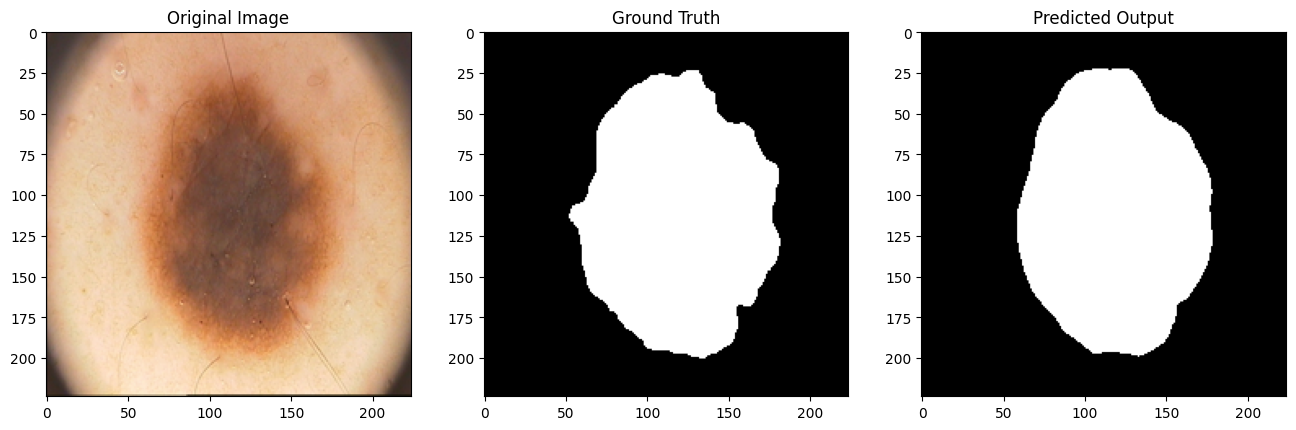

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Encode metadata using the same encoders as training
encoded_test_metadata = np.column_stack([
    metadata_encoders[col].transform(med_data_test[col].astype(str)) for col in metadata_columns
])
'''
# Load test images and masks
def load_images_from_folder(folder_path, target_size=(224, 224)):
    images = []
    for filename in sorted(os.listdir(folder_path)):  # Sort to match order with metadata
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize to target size
            images.append(img)
    return np.array(images)

x_test_images = load_images_from_folder(test_x_path) / 255.0  # Normalize to [0, 1]
y_test = load_images_from_folder(test_y_path, target_size=(224, 224))  # Masks do not need normalization
'''
# Test and visualize results
img_num = 4  # Index of the test image to visualize
test_image = X_test[img_num].reshape(1, 224, 224, 3)
test_metadata = [encoded_test_metadata[img_num, i].reshape(1, 1) for i in range(encoded_test_metadata.shape[1])]

# Load the model if needed
# model = load_model('/path/to/saved/model.h5', custom_objects={'jaccard_distance': jaccard_distance})

# Make a prediction
img_pred = model.predict([test_image] + test_metadata)
img_pred1=img_pred>0.5
# Visualize the results
plt.figure(figsize=(16, 16))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(X_test[img_num])
plt.title('Original Image')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(Y_test[img_num], cmap='binary_r')
plt.title('Ground Truth')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(img_pred1.reshape(224, 224), cmap='binary_r')
plt.title('Predicted Output')

plt.show()


In [ ]:
 x_test=X_test
 y_test=Y_test

## 6. Evaluation metrics

In [ ]:
import numpy as np
from tensorflow.keras import backend as K

# Dice and IoU score functions
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return (2. * intersection + smooth) / (union + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred = K.cast(y_pred, dtype=K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Debug shapes
print("x_test shape:", x_test.shape)
test_metadata_inputs = [encoded_test_metadata[:, i].reshape(-1, 1) for i in range(encoded_test_metadata.shape[1])]
for i, metadata in enumerate(test_metadata_inputs):
    print(f"Metadata input {i} shape:", metadata.shape)

# Predict masks
predictions = model.predict([x_test] + test_metadata_inputs)

# Binarize predictions
predictions_binary = (predictions > 0.5).astype(int)

# Calculate Dice and IoU scores
dice_scores = []
iou_scores = []

for i in range(len(y_test)):
    y_true = y_test[i]
    y_pred_bin = predictions_binary[i]

    y_true_tf = K.constant(y_true, dtype=K.floatx())
    y_pred_bin_tf = K.constant(y_pred_bin, dtype=K.floatx())

    dice = K.eval(dice_score(y_true_tf, y_pred_bin_tf))
    iou = K.eval(iou_score(y_true_tf, y_pred_bin_tf))

    dice_scores.append(dice)
    iou_scores.append(iou)

# Average metrics
average_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Print results
print(f"Average Dice Score over test set: {average_dice:.4f}")
print(f"Mean IoU over test set: {mean_iou:.4f}")


x_test shape: (40, 224, 224, 3)
Metadata input 0 shape: (40, 1)
Metadata input 1 shape: (40, 1)
Metadata input 2 shape: (40, 1)
Metadata input 3 shape: (40, 1)
Metadata input 4 shape: (40, 1)
Metadata input 5 shape: (40, 1)
Metadata input 6 shape: (40, 1)
Metadata input 7 shape: (40, 1)
Metadata input 8 shape: (40, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Average Dice Score over test set: 0.8868
Mean IoU over test set: 0.8164


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


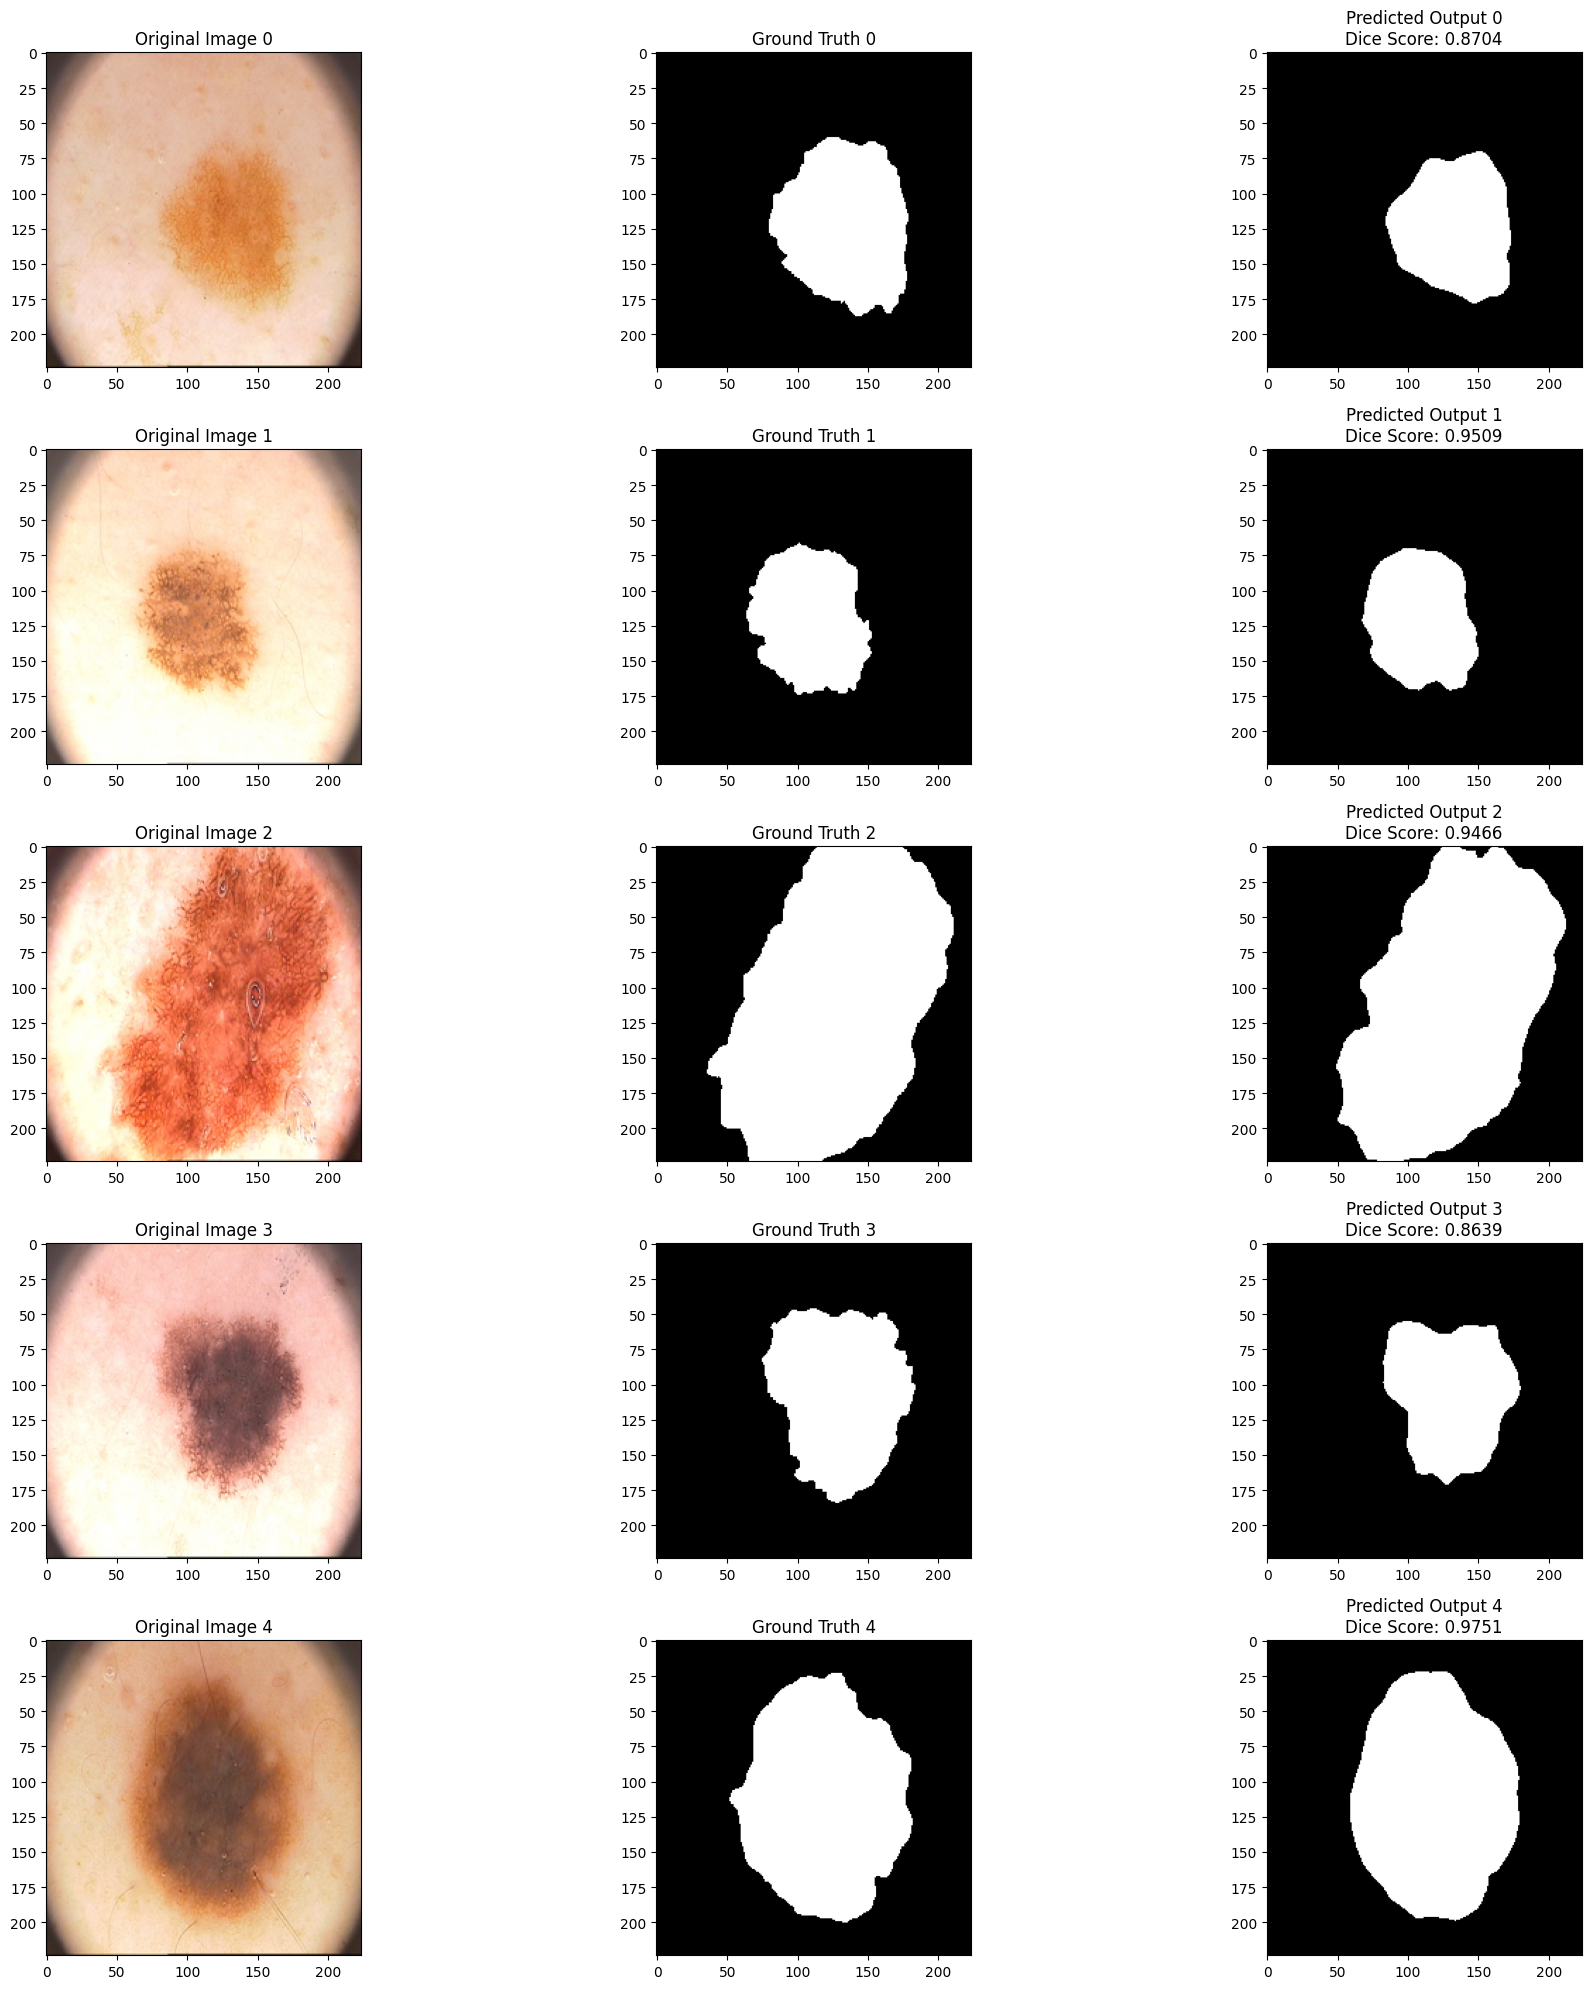

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K

num_images = 5  # Number of images to visualize

plt.figure(figsize=(20, 20))
for i in range(num_images):
    img_num = i

    # Prepare the test image and metadata inputs
    test_image = x_test[img_num].reshape(1, 224, 224, 3)
    test_metadata = [encoded_test_metadata[img_num, j].reshape(1, 1) for j in range(encoded_test_metadata.shape[1])]

    # Make predictions using the model
    img_pred = model.predict([test_image] + test_metadata)
    pred = img_pred[0]

    # Binarize predictions for comparison
    y_pred_bin = pred.reshape(224, 224) > 0.5
    y_true_bin = y_test[img_num].reshape(224, 224) > 0.5

    # Calculate the Dice score
    y_true_tf = K.constant(y_true_bin, dtype=K.floatx())
    y_pred_tf = K.constant(y_pred_bin, dtype=K.floatx())
    dice = K.eval(dice_score(y_true_tf, y_pred_tf))

    # Plot the original image
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(x_test[img_num])
    plt.title(f'Original Image {img_num}')

    # Plot the ground truth mask
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(y_test[img_num], cmap='binary_r')
    plt.title(f'Ground Truth {img_num}')

    # Plot the predicted mask
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(y_pred_bin, cmap='binary_r')
    plt.title(f'Predicted Output {img_num}\nDice Score: {dice:.4f}')

plt.tight_layout()
plt.show()
